In [1]:
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
from time import time

from mrobotics.piecewise.cubic import interpolating_path2d


# Define the test case

In [2]:
def gen_arc_points(xy_center, radius, start_radian, stop_radian, N_samples = 10):
    """generate waypoints along a circular arc

    xy_center assumed to be a Nx2 numpy array

    The waypoints will be returned ...
    *  in the same order indicated by the "start" and "stop".
    *  the first waypoint corresponds to the start of the arc
    *  the last corresponds to the end of the arc
    """
    if stop_radian - start_radian > 0.0: #CCW
        angles = np.linspace(start_radian, stop_radian, N_samples)
        sign = +1
    else: #CW
        angles = np.linspace(stop_radian, start_radian, N_samples)#[::-1]
        sign = -1
    xy_arc = radius * np.vstack([np.cos(angles), np.sin(sign*angles)]).T
    return np.array(xy_center).reshape(1,2) + xy_arc

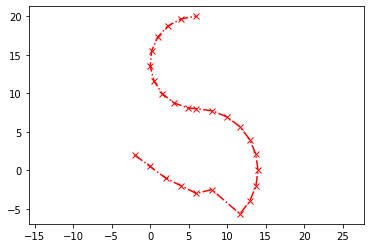

In [3]:
r1 = 8.0
r2 = 6.0
my_waypoints = np.array([
    [-2.0,2.0],
    [0.0,0.5],
    [2.0,-1.0],
    [4.0, -2.0],
    [6.0, -3.0],
    [8.0, -2.5],  # <--- ends at 6
    *gen_arc_points(xy_center=[6,0],radius=r1, start_radian=-np.pi/4,  stop_radian=np.pi/2, N_samples=10), # ends at 16
    *gen_arc_points(xy_center=[6,r1+r2],radius=r2, start_radian=np.pi*1.5,  stop_radian=np.deg2rad(100))
])
plt.plot(*my_waypoints.T,'-.xr')
plt.axis('equal')
plt.show()

In [4]:
my_curve = interpolating_path2d(my_waypoints)

# Very basic: zeroth-order

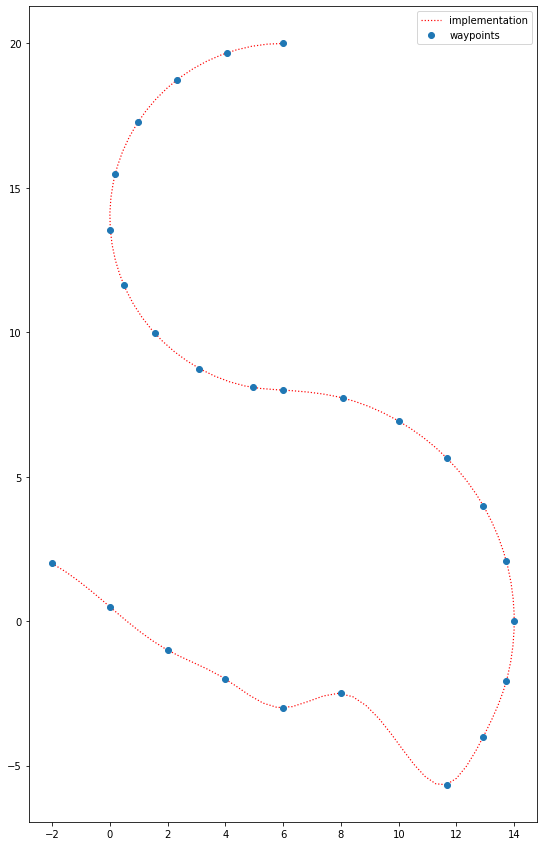

In [5]:
t_eval = np.linspace(my_curve.idx2arclen[0], my_curve.idx2arclen[-1],100) # within the domain of definition
pts_test = my_curve.get_pos(t_eval)
_, ax = plt.subplots(figsize=(12,15))
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation')
ax.plot(*my_waypoints.T, 'o', label='waypoints')
ax.set_aspect('equal')
ax.legend()
plt.show()

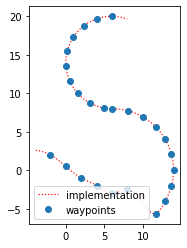

In [6]:
# what about extrapolation?
t_eval = np.linspace(my_curve.idx2arclen[0]-2, my_curve.idx2arclen[-1]+2,100) 
pts_test = my_curve.get_pos(t_eval)
_, ax = plt.subplots()
ax.plot(*pts_test.T, ':r',lw=1.2, label='implementation')
ax.plot(*my_waypoints.T, 'o', label='waypoints')
ax.set_aspect('equal')
ax.legend()
plt.show()

# First-order
* correctness of the unit tangent?
* let's see how bad/good the approximate arc-length parameterization is --- speed wrt path parameter

In [7]:
t_eval = np.linspace(my_curve.idx2arclen[0], my_curve.idx2arclen[-1],100) # within the domain of definition
pts_test = my_curve.get_utang(t_eval)
np.testing.assert_allclose(np.linalg.norm(pts_test, axis=1, ord=2) ,1.0)

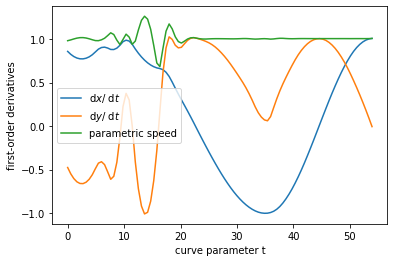

In [8]:
t_eval = np.linspace(my_curve.idx2arclen[0], my_curve.idx2arclen[-1],100) # within the domain of definition
velocity = my_curve.get_tang(t_eval)
plt.plot(t_eval, velocity[:,0], label="d$x$/ d$t$")
plt.plot(t_eval, velocity[:,1], label="d$y$/ d$t$")
plt.plot(t_eval, np.linalg.norm(velocity,axis=1,ord=2), label="parametric speed")
plt.xlabel('curve parameter t')
plt.ylabel('first-order derivatives')
plt.legend()
plt.show()

# Second-order
We will only look at the curvature values

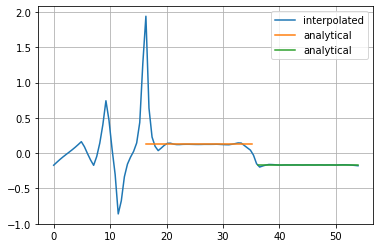

In [9]:
t_eval = np.linspace(my_curve.idx2arclen[0], my_curve.idx2arclen[-1],100) # within the domain of definition
velocity = my_curve.get_tang(t_eval)
velocity2, k = my_curve.get_tang_and_curv(t_eval)
np.testing.assert_allclose(velocity, velocity2)

plt.plot(t_eval, k, label='interpolated')
plt.plot([my_curve.idx2arclen[6],my_curve.idx2arclen[15]], [1/r1, 1/r1], label='analytical')
plt.plot([my_curve.idx2arclen[16],my_curve.idx2arclen[-1]], [-1/r2, -1/r2], label='analytical')
plt.grid('both')
plt.legend()
plt.show() # does the last part (the circular arc) has the expected sign and curvature (expected to be approximately 1/radius) ?



# Estimating progress along the path

* Does the `project` method inherited from the waypoint superclass still works good enough?

## Testing cases 1a and 1b

Now, we are testing some query points around the curve at t = 26.96 m (see the black cross in the plot).


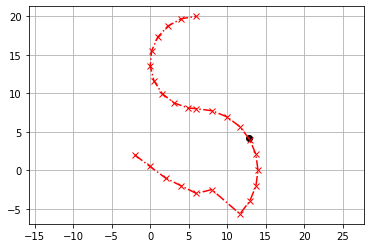

In [10]:
probe_s = my_curve.get_tot_dist()*0.5
print(f"Now, we are testing some query points around the curve at t = {probe_s:.2f} m (see the black cross in the plot).")
plt.plot(*my_curve.get_pos(probe_s).T,'ok')

plt.plot(*my_waypoints.T,'-.xr')
plt.axis('equal')
plt.grid()

plt.show()


In [11]:
# some query point around that probed point
# test case 1a
test_query_pt = np.array([15.0,5.0]) 

for init_guess in (20.0, 26.0 , 33.0):
    t0 = time()
    res = my_curve.project(test_query_pt ,arclength_init_guess=init_guess, soln_tolerance=0.005, iter_max=10, verbose=True)
    t1 = time()
    # calculate also the projected distance (for debugging/ extra info)
    final_pos, final_u_tang_vec = my_curve.get_pos_utang(res, clip=False)
    final_u_normal_vec = np.array([final_u_tang_vec[1], - final_u_tang_vec[0]])
    dist = np.abs(np.dot(test_query_pt-final_pos, final_u_normal_vec) )
    print(
        f"init guess: {init_guess:.2f}", f"final iterate: {res:.2f}",  
        f"normal distance: {dist:.2}", f"took {(t1-t0)*1e3:.2} ms", sep=', ') 

working on iteration 0: new iterate 27.606
working on iteration 1: new iterate 26.407
working on iteration 2: new iterate 26.755
working on iteration 3: new iterate 26.653
working on iteration 4: new iterate 26.683
working on iteration 5: new iterate 26.674
working on iteration 6: new iterate 26.677
init guess: 20.00, final iterate: 26.68, normal distance: 2.3, took 1.1 ms
working on iteration 0: new iterate 26.872
working on iteration 1: new iterate 26.619
working on iteration 2: new iterate 26.693
working on iteration 3: new iterate 26.672
working on iteration 4: new iterate 26.678
working on iteration 5: new iterate 26.676
init guess: 26.00, final iterate: 26.68, normal distance: 2.3, took 0.65 ms
working on iteration 0: new iterate 25.677
working on iteration 1: new iterate 26.963
working on iteration 2: new iterate 26.592
working on iteration 3: new iterate 26.701
working on iteration 4: new iterate 26.669
working on iteration 5: new iterate 26.679
working on iteration 6: new iter

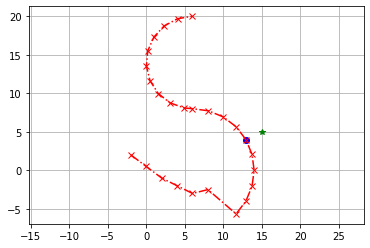

In [12]:
plt.plot(*my_curve.get_pos(26.68).T,'ob')
plt.plot(*test_query_pt.T,'*g')


plt.plot(*my_waypoints.T,'-.xr')
plt.axis('equal')
plt.grid()

plt.show()

In [13]:
# some query point around that probed point
# test case 1b
test_query_pt = np.array([10.0,5.0]) 

for init_guess in (20.0, 26.0 , 33.0):
    t0 = time()
    res = my_curve.project(test_query_pt ,arclength_init_guess=init_guess, soln_tolerance=0.005, iter_max=10, verbose=True)
    t1 = time()
    # calculate also the projected distance (for debugging/ extra info)
    final_pos, final_u_tang_vec = my_curve.get_pos_utang(res, clip=False)
    final_u_normal_vec = np.array([final_u_tang_vec[1], - final_u_tang_vec[0]])
    dist = np.abs(np.dot(test_query_pt-final_pos, final_u_normal_vec) )
    print(
        f"init guess: {init_guess:.2f}", f"final iterate: {res:.2f}",  
        f"normal distance: {dist:.2}", f"took {(t1-t0)*1e3:.2} ms", sep=', ') 

working on iteration 0: new iterate 25.929
working on iteration 1: new iterate 28.900
working on iteration 2: new iterate 29.605
working on iteration 3: new iterate 29.746
working on iteration 4: new iterate 29.774
working on iteration 5: new iterate 29.780
working on iteration 6: new iterate 29.781
init guess: 20.00, final iterate: 29.78, normal distance: 1.6, took 1.5 ms
working on iteration 0: new iterate 28.920
working on iteration 1: new iterate 29.609
working on iteration 2: new iterate 29.747
working on iteration 3: new iterate 29.774
working on iteration 4: new iterate 29.780
working on iteration 5: new iterate 29.781
init guess: 26.00, final iterate: 29.78, normal distance: 1.6, took 0.47 ms
working on iteration 0: new iterate 30.513
working on iteration 1: new iterate 29.922
working on iteration 2: new iterate 29.808
working on iteration 3: new iterate 29.786
working on iteration 4: new iterate 29.782
init guess: 33.00, final iterate: 29.78, normal distance: 1.6, took 0.39 ms

In [14]:
# print(my_curve.idx2arclen[-15:])

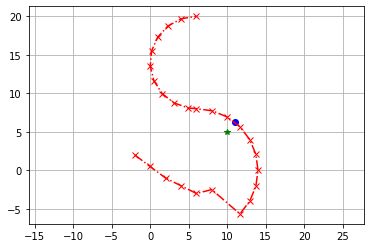

In [15]:
plt.plot(*my_curve.get_pos(29.78).T,'ob')
plt.plot(*test_query_pt.T,'*g')


plt.plot(*my_waypoints.T,'-.xr')
plt.axis('equal')
plt.grid()

plt.show()

## Testing case 2

In [16]:
test_query_pt = np.array([2.0,15.0])
for init_guess in (33.0, 44.0, 60.0):
    t0 = time()
    res = my_curve.project(test_query_pt ,arclength_init_guess=init_guess, soln_tolerance=0.005, iter_max=10, verbose=True)
    t1 = time()
    # calculate also the projected distance (for debugging/ extra info)
    final_pos, final_u_tang_vec = my_curve.get_pos_utang(res, clip=False)
    final_u_normal_vec = np.array([final_u_tang_vec[1], - final_u_tang_vec[0]])
    dist = np.abs(np.dot(test_query_pt-final_pos, final_u_normal_vec) )
    print(
        f"init guess: {init_guess:.2f}", f"final iterate: {res:.2f}",  
        f"normal distance: {dist:.2}", f"took {(t1-t0)*1e3:.2} ms", sep=', ') 

working on iteration 0: new iterate 40.791
working on iteration 1: new iterate 43.953
working on iteration 2: new iterate 45.344
working on iteration 3: new iterate 45.802
working on iteration 4: new iterate 45.945
working on iteration 5: new iterate 45.989
working on iteration 6: new iterate 46.003
working on iteration 7: new iterate 46.007
init guess: 33.00, final iterate: 46.01, normal distance: 1.9, took 2.5 ms
working on iteration 0: new iterate 45.361
working on iteration 1: new iterate 45.807
working on iteration 2: new iterate 45.946
working on iteration 3: new iterate 45.989
working on iteration 4: new iterate 46.003
working on iteration 5: new iterate 46.007
init guess: 44.00, final iterate: 46.01, normal distance: 1.9, took 0.75 ms
working on iteration 0: new iterate 57.503
working on iteration 1: new iterate 54.249
working on iteration 2: new iterate 50.255
working on iteration 3: new iterate 47.567
working on iteration 4: new iterate 46.503
working on iteration 5: new iter

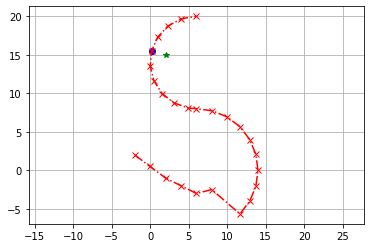

In [17]:
plt.plot(*my_curve.get_pos(46.01).T,'ob')
plt.plot(*test_query_pt.T,'*g')


plt.plot(*my_waypoints.T,'-.xr')
plt.axis('equal')
plt.grid()

plt.show()

TODO try Exact Newton for the projection instead --- I guess it will be way more efficient.
(still keep `get_pos_utang` and `project`? a new method `project_Newton` instead?)